In [1]:
import math
import time
import gc
import os
import re


import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.animation import FuncAnimation, PillowWriter


/home/wellscrosby/miniconda3/envs/mlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wellscrosby/miniconda3/envs/mlp/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wellscrosby/miniconda3/envs/mlp/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
gc.collect()

assert torch.cuda.is_available(), "Should use GPU-enabled colab"

device = torch.device('cuda:0')

In [3]:
print(torch.cuda.is_available())

True


In [4]:
kernel_size = 51

In [5]:
def isolated_plot_grid(x):
    plt.figure(figsize=(10, 10))
    plt.imshow(x[0, 0].cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Grids')
    plt.show()

In [6]:
# class GridCell(nn.Module):
#     def __init__(self, kernel_size):
#         super(GridCell, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding=0, bias=False)  # Set padding to 0

#     def custom_padding(self, x, pad_size):
#         # # isolated_plot_grid(x)
#         # # print(x.shape)
#         # width = x.shape[2]
#         # x = torch.cat((x[:, :, :, -pad_size:], x, x[:, :, :, :pad_size]), dim=3)
#         # # isolated_plot_grid(x)
#         # # print(x.shape)
#         # x = torch.cat((torch.roll(x[:, :, -pad_size:, :], width//2 ,3), x, torch.roll(x[:, :, :pad_size, :], width//2 ,3)), dim=2)
#         # # isolated_plot_grid(x)
#         # # print(x.shape)
#         # return x
    
#         x = torch.cat((x[:, :, :, -pad_size:], x, x[:, :, :, :pad_size]), dim=3)
#         x = torch.cat((x[:, :, -pad_size:, :], x, x[:, :, :pad_size, :]), dim=2)
#         return x


#     def forward(self, x):
#         pad_size = self.conv1.kernel_size[0] // 2
#         x = self.custom_padding(x, pad_size)
#         x = self.conv1(x)
#         return x

# # Instantiate the model
# model = GridCell(kernel_size).to(device)
# print(model)

In [7]:
class GridCell(nn.Module):
    def __init__(self, kernel_size):
        super(GridCell, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False, padding_mode="circular")  # Set padding to 0



    def forward(self, x):
        x = self.conv1(x)
        return x

# Instantiate the model
model = GridCell(kernel_size).to(device)
print(model)

GridCell(
  (conv1): Conv2d(1, 1, kernel_size=(51, 51), stride=(1, 1), padding=(25, 25), bias=False, padding_mode=circular)
)


In [8]:
def gaussian(x, mu, sigma):
    return (1 / (sigma * (2 * np.pi)**0.5)) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def center_surround(distance, width):
    factor = (3 * np.pi) / 2
    return np.cos((distance / width) * factor) * gaussian((distance / width) * factor, 0, 2.9)
    # return (np.exp(-((distance*(2/width)) ** 2)) -0.25) * 2

def make_filter(size):
    x = torch.zeros_like(model.conv1.weight)
    center = (size - 1) / 2
    
    # print(((center - center) ** 2 + (j - center) ** 2) ** 0.5)
    for i in range(size):
        for j in range(size):
            dist_from_center = ((i - center) ** 2 + (j - center) ** 2) ** 0.5
            x[0, 0, i, j] = center_surround(dist_from_center, center)
    mean = torch.mean(x)
    x = x - mean
    return x

tensor(-2.6226e-06, device='cuda:0')


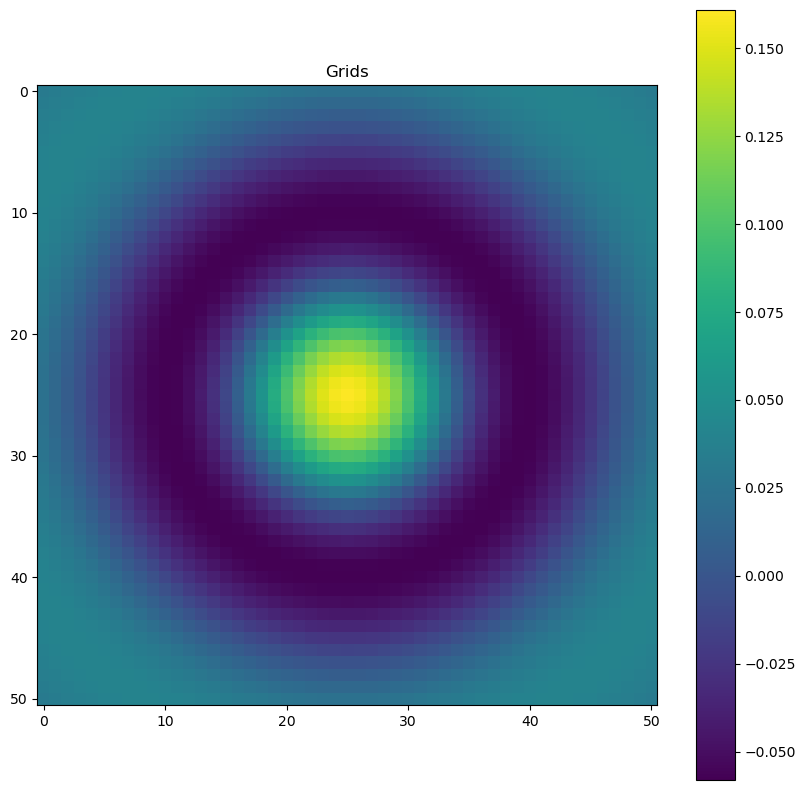

In [9]:
# Manually set the weights and biases of the conv1 layer
with torch.no_grad():
    weights = make_filter(kernel_size).to(device)
    print(weights.sum())
    model.conv1.weight = nn.Parameter(weights)
    # model.conv1.bias = nn.Parameter(torch.zeros_like(model.conv1.bias))
    
isolated_plot_grid(model.conv1.weight)

In [10]:
def find_peaks(x):
    peaks = []
    for i in range(1, x.shape[0] - 1):
        if x[i] > x[i - 1] and x[i] > x[i + 1]:
            peaks.append(i)
    return peaks

Processing:   0%|          | 0/10000 [00:00<?, ?it/s]

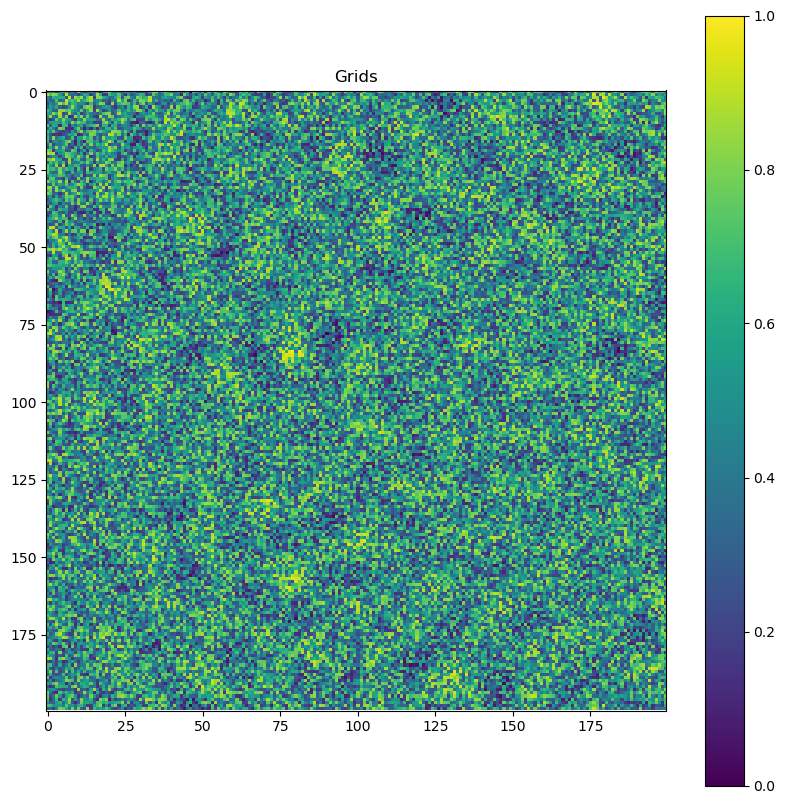

Processing:   2%|▏         | 207/10000 [00:00<00:18, 540.95it/s]

[4, 7, 9, 12, 14, 16, 18, 20, 23, 26, 29, 32, 35, 38, 41, 44, 46, 49, 52, 55, 59, 61, 63, 67, 72, 76, 79, 83, 86, 88, 91, 95, 97, 99, 102, 104, 107, 112, 118, 120, 122, 126, 130, 133, 136, 141, 144, 147, 150, 152, 154, 157, 160, 164, 168, 170, 173, 175, 177, 180, 183, 186, 188, 190, 192, 195, 197]


Processing:   9%|▉         | 892/10000 [00:01<00:07, 1234.31it/s]

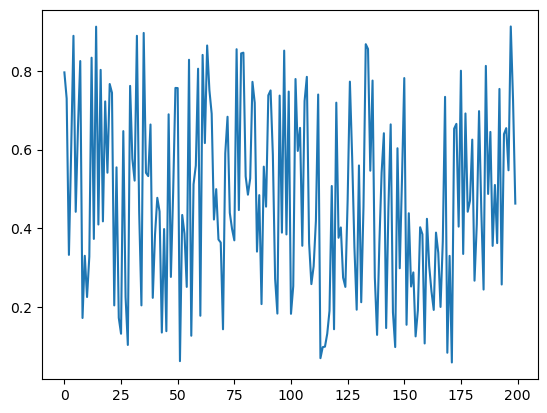

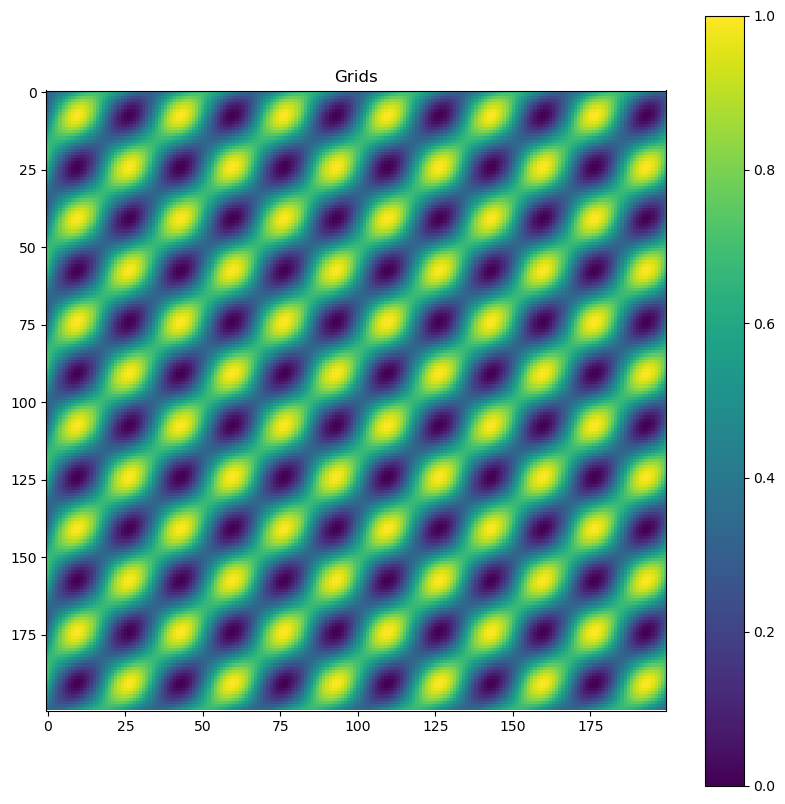

Processing:  12%|█▏        | 1162/10000 [00:01<00:09, 884.87it/s]

[16, 49, 83, 116, 149, 183]


Processing:  20%|█▉        | 1989/10000 [00:02<00:06, 1291.77it/s]

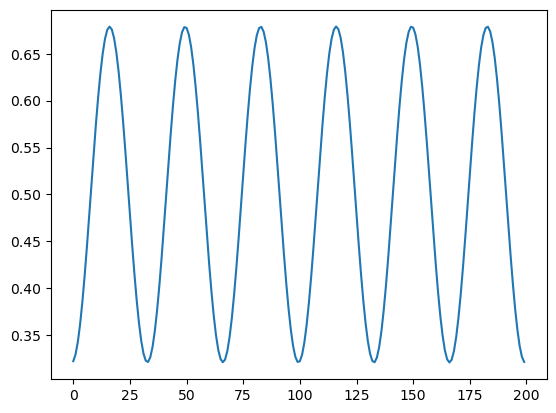

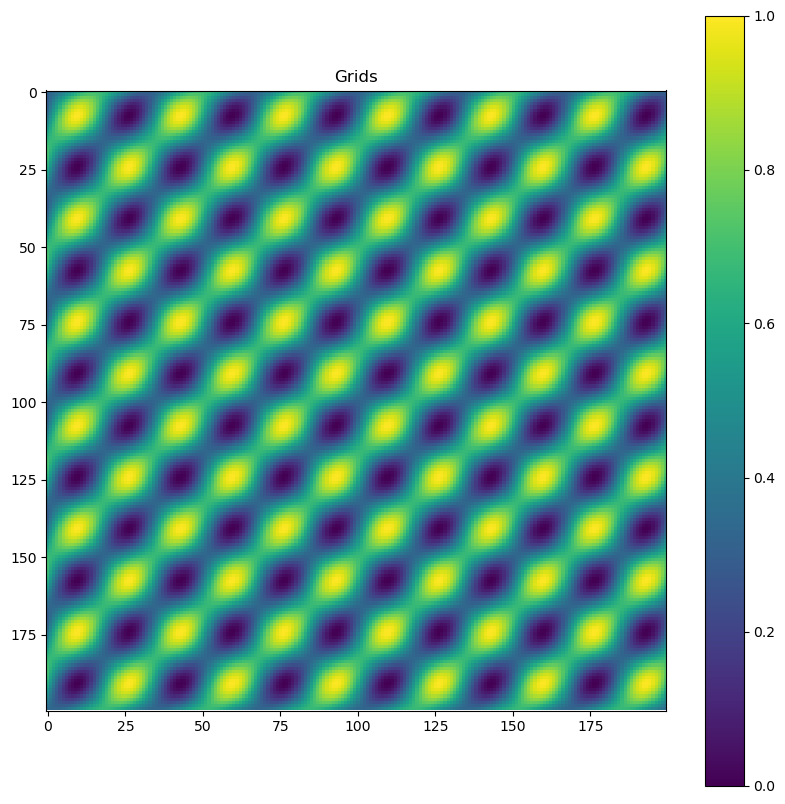

Processing:  23%|██▎       | 2260/10000 [00:02<00:08, 928.81it/s] 

[16, 49, 83, 116, 149, 183]


Processing:  29%|██▉       | 2938/10000 [00:02<00:05, 1257.72it/s]

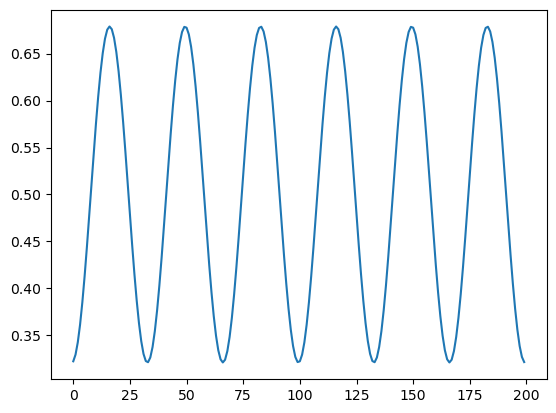

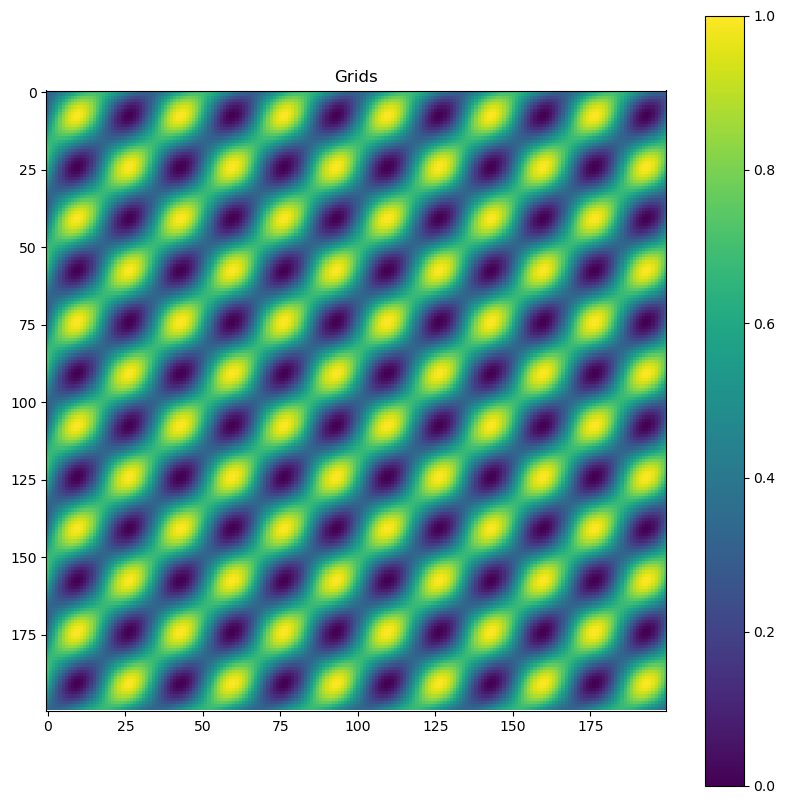

Processing:  32%|███▏      | 3208/10000 [00:03<00:07, 930.04it/s] 

[16, 49, 83, 116, 149, 183]


Processing:  39%|███▉      | 3885/10000 [00:03<00:04, 1256.80it/s]

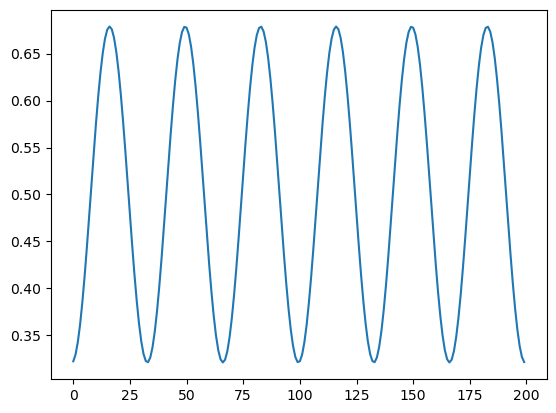

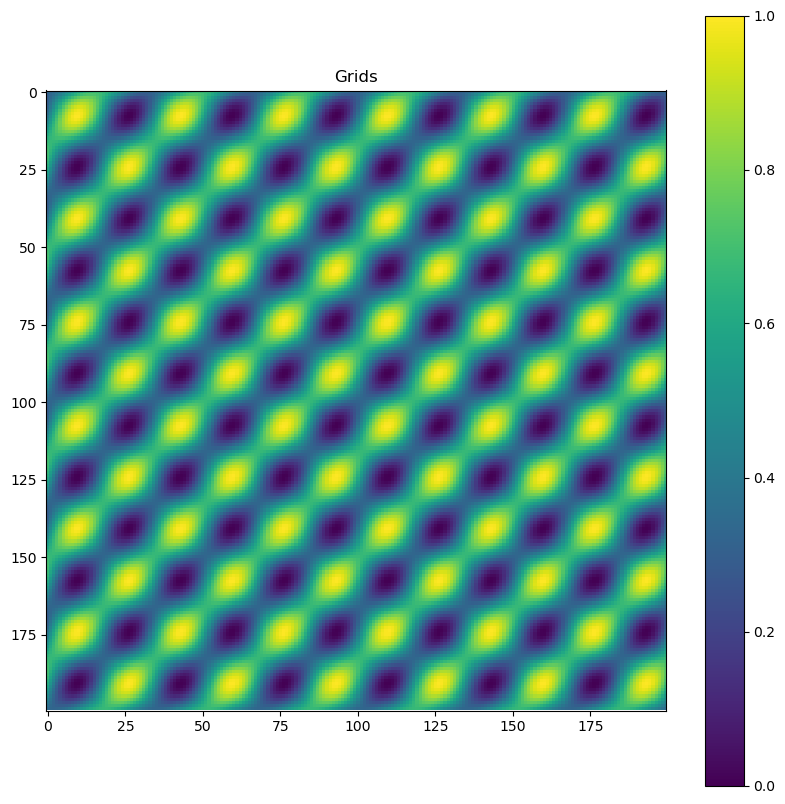

Processing:  42%|████▏     | 4155/10000 [00:04<00:06, 920.65it/s] 

[16, 49, 83, 116, 149, 183]


Processing:  50%|████▉     | 4978/10000 [00:04<00:03, 1295.25it/s]

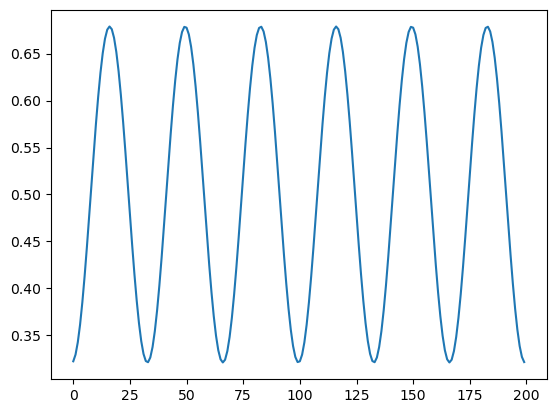

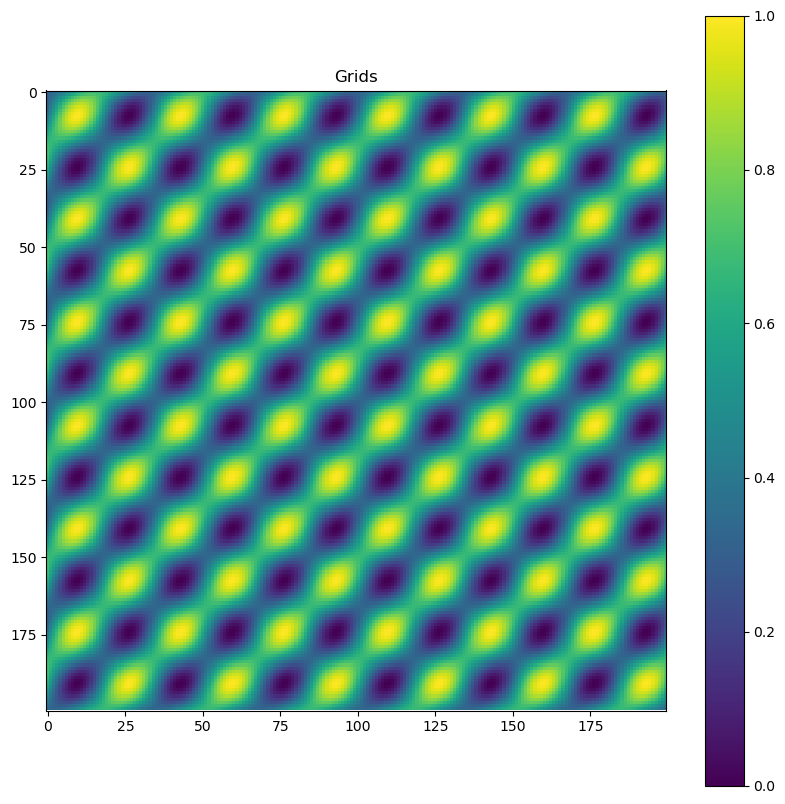

Processing:  52%|█████▏    | 5248/10000 [00:05<00:05, 926.42it/s] 

[16, 49, 83, 116, 149, 183]


Processing:  59%|█████▉    | 5931/10000 [00:05<00:03, 1263.77it/s]

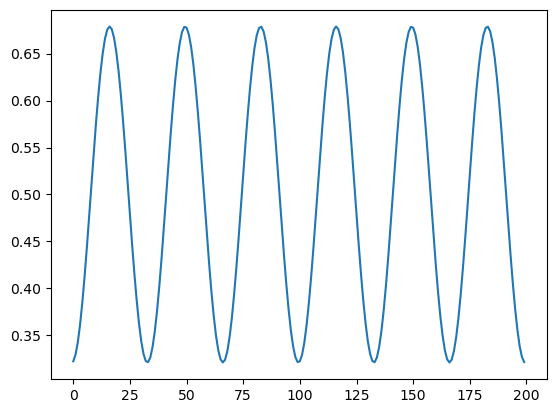

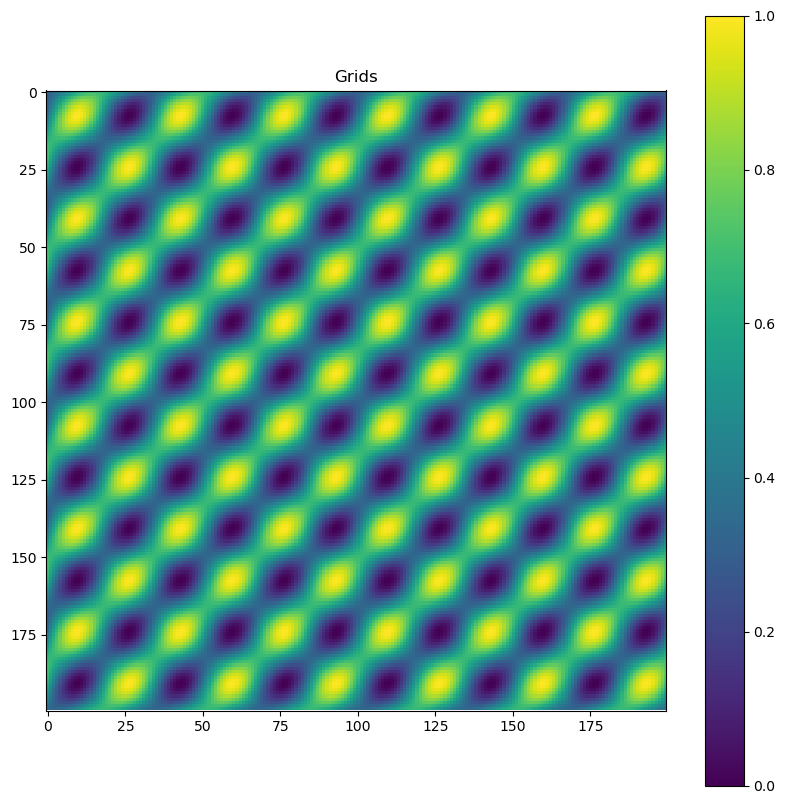

Processing:  62%|██████▏   | 6197/10000 [00:06<00:04, 920.39it/s] 

[16, 49, 83, 116, 149, 183]


Processing:  69%|██████▊   | 6869/10000 [00:06<00:02, 1248.50it/s]

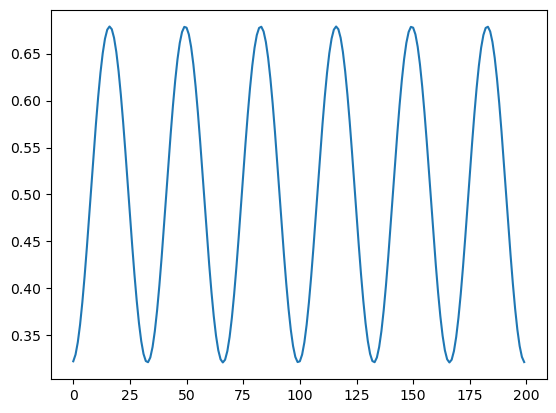

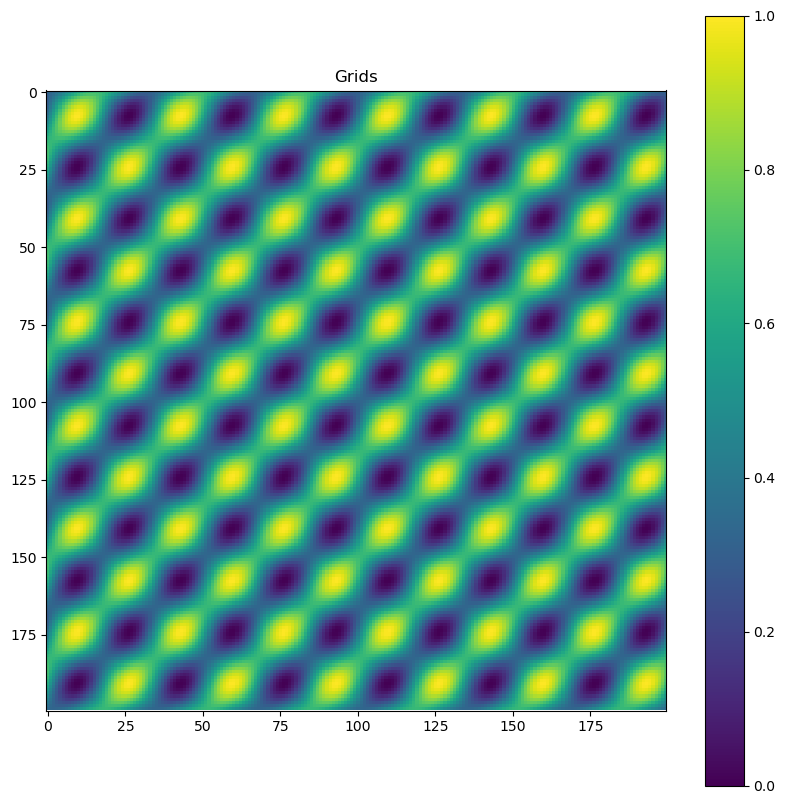

Processing:  73%|███████▎  | 7273/10000 [00:07<00:02, 1003.56it/s]

[16, 49, 83, 116, 149, 183]


Processing:  80%|███████▉  | 7952/10000 [00:07<00:01, 1280.79it/s]

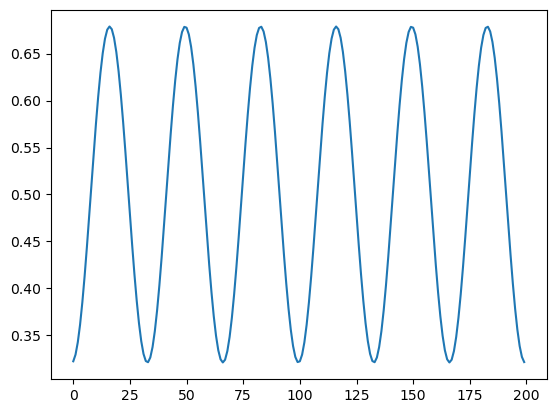

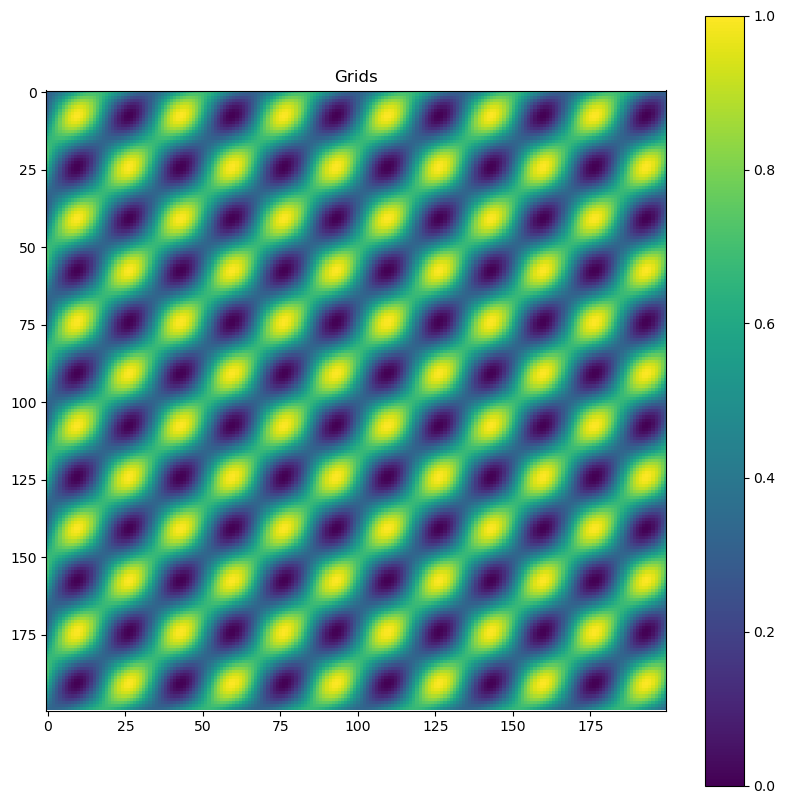

Processing:  82%|████████▏ | 8223/10000 [00:08<00:01, 923.15it/s] 

[16, 49, 83, 116, 149, 183]


Processing:  89%|████████▉ | 8900/10000 [00:08<00:00, 1252.80it/s]

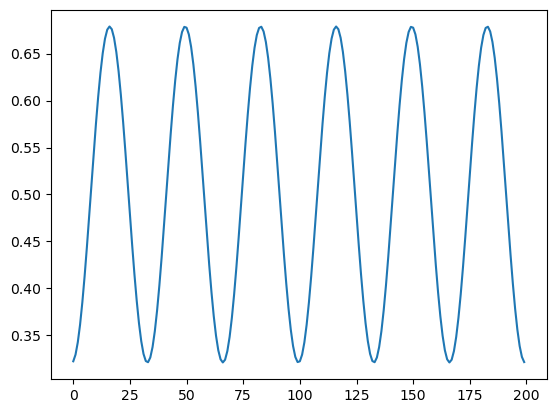

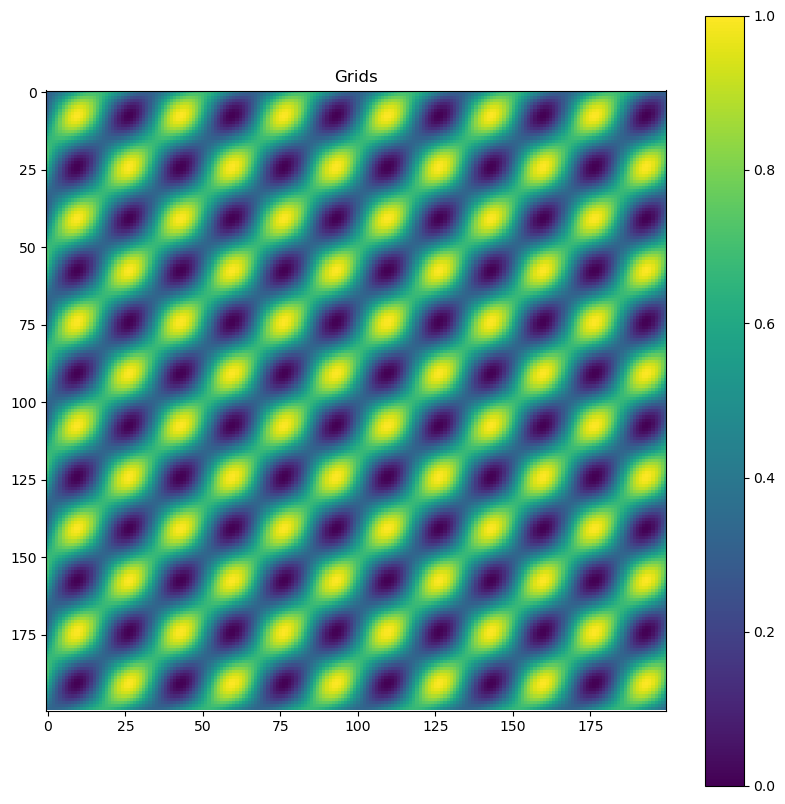

Processing:  92%|█████████▏| 9169/10000 [00:09<00:00, 917.10it/s] 

[16, 49, 83, 116, 149, 183]


Processing: 100%|██████████| 10000/10000 [00:09<00:00, 1037.37it/s]


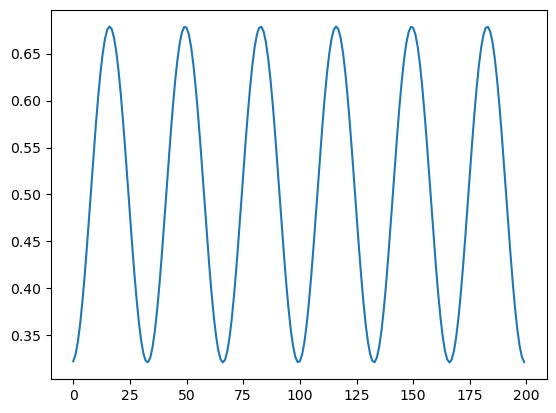

In [15]:
torch.cuda.empty_cache()
gc.collect()

portion_update = 0.1
random_factor = 0.0001

width = 200
# height = int(width * np.sqrt(3)/2)
height = 200
num_iters = 10000

# grids = torch.rand(1, 1, grid_size, grid_size).to(device) / np.sqrt(2)
# grids = torch.rand(1, 1, height, width).to(device)
grids = torch.zeros(1, 1, height, width).to(device)
# grids[0, 0, grid_size//2, grid_size//2] = 1

# model(grids)

# Forward pass
with torch.no_grad():
    for i in tqdm(range(num_iters), desc="Processing"):
        # print(grids.shape)
        
        random_deviation = torch.rand(1, 1, height, width).to(device) * random_factor
        grids = (1 - portion_update) * grids + portion_update * (model(grids) + random_deviation)
        
        
        
        grids = (1 - portion_update) * grids + portion_update * model(grids)
        
        
        # normalize
        grids = (grids - grids.min()) / (grids.max() - grids.min())
        # in grid center add some value
        # grids[0, 0, int(height* (i/num_iters)), :] = 1
        
        # deviation = int(10 * (i/num_iters))
        
        # for j in range(0, height, 20):
        #     for k in range(0, width, 20):
        #         grids[0, 0, (j + deviation)%height, (k+ deviation)% width] = 1
        
        
        if i % 1000 == 0:
            isolated_plot_grid(grids)
            slice_across = grids[0,0, height//2, :].cpu().detach().numpy()
            plt.plot(slice_across)
            print(find_peaks(slice_across))

In [11]:
def get_next_filename(directory, base_name, extension):
    files = os.listdir(directory)
    pattern = re.compile(rf"{base_name}_(\d+){extension}")
    numbers = [int(pattern.match(f).group(1)) for f in files if pattern.match(f)]
    next_number = max(numbers, default=0) + 1
    return os.path.join(directory, f"{base_name}_{next_number}{extension}")

In [12]:
def plot_grid(grids, ax):
    ax.clear()
    im = ax.imshow(grids[0, 0].cpu().detach().numpy(), cmap='viridis')
    return im

torch.cuda.empty_cache()
gc.collect()

portion_update = 0.1
random_factor = 0.0001

grid_size = 100
num_iters = 10000
num_frames = 100
num_deviation = 30

iters_per_frame = num_iters // num_frames

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# grids = torch.zeros(1, 1, grid_size, grid_size).to(device)
grids = torch.rand(1, 1, grid_size, grid_size).to(device)


fig, ax = plt.subplots(figsize=(10, 10))

progress_bar = tqdm(total=num_frames, desc="Processing frames")

def update(frame):
    global grids
    
    for i in range(iters_per_frame):
        cur_iter = (frame * iters_per_frame) + i
        
        random_deviation = torch.rand(1, 1, grid_size, grid_size).to(device) * random_factor
        grids = (1 - portion_update) * grids + portion_update * (model(grids) + random_deviation)
        grids = (grids - grids.min()) / (grids.max() - grids.min())

        # index = int((frame/num_iters) * 2)
        # grids[0, 0, (index - 1)%grid_size, :] = 0.8
        # grids[0, 0, index, :] = 1
        # grids[0, 0, (index + 1)%grid_size, :] = 0.8
        
        # grids[0, 0, (grid_size//2) - 1, :] = 0.8
        # grids[0, 0, grid_size//2, :] = 1
        # grids[0, 0, (grid_size//2) + 1, :] = 0.8
        
        deviation = int(num_deviation * (cur_iter/num_iters))
        
        for j in range(0, grid_size, 20):
            for k in range(0, grid_size, 20):
                grids[0, 0, (j + deviation)%grid_size, (k+ deviation)% grid_size] = 1
                grids[0, 0, ((j + deviation + 10)%grid_size), ((k+ deviation + 10)% grid_size)] = 1
            
    im = plot_grid(grids, ax)
    
    progress_bar.update(1)
    progress_bar.set_description(f"Processing frame {frame + 1}/{num_frames}")
    
    return [im]

ani = FuncAnimation(fig, update, frames=num_frames, blit=True)

# Save the animation as an MP4 file
output_directory = 'videos'
base_filename = 'grids_evolution'
file_extension = '.mp4'
output_filename = get_next_filename(output_directory, base_filename, file_extension)
ani.save(output_filename, fps=30)

plt.close()

Processing frame 100/100: : 103it [00:27,  3.76it/s]                      

In [11]:
import pygame

def plot_grid(grids):
    grid_np = grids[0, 0].cpu().detach().numpy()
    return grid_np

torch.cuda.empty_cache()
gc.collect()

portion_update = 0.3
random_factor = 0.0001

iters_per_frame = 10
spacing = int(kernel_size * (4/5))
half_spacing = spacing // 2
grid_size = spacing * 4
move_per_frame = 0.25



print(spacing, half_spacing)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grids = torch.rand(1, 1, grid_size, grid_size).to(device)

# Initialize pygame
pygame.init()
window_size = (800, 800)
screen = pygame.display.set_mode(window_size)
pygame.display.set_caption("Grid Evolution")


def update_grid(grids, deviation_x, deviation_y, i):
    with torch.no_grad():
        for _ in range(iters_per_frame):
            random_deviation = torch.rand(1, 1, grid_size, grid_size).to(device) * random_factor
            grids = (1 - portion_update) * grids + portion_update * (model(grids) + random_deviation)
            grids = (grids - grids.min()) / (grids.max() - grids.min())
            
            for j in range(0, grid_size, spacing):
                for k in range(0, grid_size, spacing):
                    # if i == 0:
                    #     print(j, k, (j + deviation_y) % grid_size, (k + deviation_x) % grid_size)
                    grids[0, 0, (j + deviation_y) % grid_size, (k + deviation_x) % grid_size] = 1
                    grids[0, 0, (j + half_spacing + deviation_y) % grid_size, (k + half_spacing + deviation_x) % grid_size] = 1
    return grids

running = True
clock = pygame.time.Clock()

# Initialize deviation
deviation_x = 0
deviation_y = 0

i = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
            
    keys = pygame.key.get_pressed()
    if keys[pygame.K_a]:
        deviation_y -= move_per_frame
    if keys[pygame.K_d]:
        deviation_y += move_per_frame
    if keys[pygame.K_w]:
        deviation_x -= move_per_frame
    if keys[pygame.K_s]:
        deviation_x += move_per_frame
        
    grids = update_grid(grids, int(deviation_x), int(deviation_y), i)
    grid_np = plot_grid(grids)
    scaled_grid = (grid_np * 255).astype(np.uint8)
    
    rgb_grid = np.stack((scaled_grid,) * 3, axis=-1)
    
    rgb_grid[:, :, 0] = (rgb_grid[:, :, 0].astype(np.float32) * 0.5).astype(np.uint8)
    
    # Render the grid using pygame
    surface = pygame.surfarray.make_surface(rgb_grid)
    surface = pygame.transform.scale(surface, window_size)
    screen.blit(surface, (0, 0))
    pygame.display.flip()   
    
    clock.tick(30)  # Limit to 30 frames per second
    i += 1

pygame.quit()

pygame 2.2.0 (SDL 2.30.7, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
40 20
